## Implementation of Simple Transformer Layer with Multi-head Attention (Multiple Transformer Layers)

In [52]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt

In [53]:
datafile = "./data/2025-07-12_full_training_data_398180_samples.csv"

In [54]:
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Mac Metal Performance Shaders
    print(f"Training on device: {device} (Mac GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Training on device: {device} (NVIDIA GPU)")
else:
    device = torch.device('cpu')
    print(f"Training on device: {device} (CPU)")

print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("Using Mac Metal Performance Shaders for GPU acceleration")

print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("Using Mac Metal Performance Shaders for GPU acceleration")

Training on device: mps (Mac GPU)
PyTorch version: 2.9.0.dev20250704
Using Mac Metal Performance Shaders for GPU acceleration
PyTorch version: 2.9.0.dev20250704
Using Mac Metal Performance Shaders for GPU acceleration


In [55]:

class AttentionBlock(nn.Module):
    """Transformer layer for metabolic modeling"""
    def __init__(self,vocab_size=115,dim=6,num_heads=2):
        super(AttentionBlock, self).__init__()

        assert dim%num_heads==0, "model dimension must be divisible by number of heads"
        self.vocab_size = vocab_size
        self.d_model = dim
        
        self.layer_norm = nn.LayerNorm(dim)
        self.num_heads = num_heads
        self.k = dim//num_heads

        self.W_k = nn.Linear(dim,self.k,bias=False)
        self.W_q = nn.Linear(dim,self.k,bias=False)
        self.W_v = nn.Linear(dim,self.k,bias=False)
        self.W_o = nn.Linear(self.k,dim,bias=False)
        #self.W_c = nn.Linear(vocab_size,vocab_size,bias=False)

    def scaled_dot_product_attention(self,keys,queries,values):
        # Find the product if K and Q transpose and divide by the square root of the model dimension (d_model)

        pre_softmax_attention_matrix = torch.einsum('bij,bkj->bik', keys,queries)/np.sqrt(self.d_model)
        attention_matrix = torch.softmax(pre_softmax_attention_matrix,dim=-1)
        attention_output = torch.einsum( 'bij,bjk->bik' , attention_matrix, values)

        return attention_output, attention_matrix

    def forward(self,x,c):
        norm_x = self.layer_norm(x)
        #modified_c = self.W_c(c.transpose(-2,-1)).transpose(-2,-1)
        modified_c = c

        Q = self.W_k(norm_x)
        K = self.W_q(norm_x)
        V = self.W_v(norm_x)

        attention_output, attention_matrix = self.scaled_dot_product_attention(Q,K,V)

        #print(attention_matrix.size(),modified_c.size())

        attended_c = torch.einsum('bij,bjk->bik',attention_matrix,modified_c)
        
        #print(c.size(),attended_c.size())

        output_x = self.W_o(attention_output) + x*(1/self.num_heads)
        output_c = (attended_c + c)*(1/self.num_heads)

        return output_x, output_c


In [56]:

class MultiHeadAttentionBlock(nn.Module):
    """Multi-Head Attention layer for metabolic modeling"""
    def __init__(self,vocab_size=115,dim=6,num_heads=2):
        super(MultiHeadAttentionBlock, self).__init__()

        self.attention_blocks = nn.ModuleList([AttentionBlock(vocab_size,dim,num_heads) for _ in range(num_heads)])

    def forward(self,x,c):

        output_x = torch.zeros_like(x)
        output_c = torch.zeros_like(c)

        for attention_block in self.attention_blocks:
            o_x, o_c = attention_block(x,c)
            output_x += o_x
            output_c += o_c

        return output_x, output_c

        

In [57]:
class FeedForwardBlock(nn.Module):

    def __init__(self,d_model,inner_dim_multiplier,dropout=0.1):
        super(FeedForwardBlock, self).__init__()

        self.d_model = d_model+1
        self.inner_dim = inner_dim_multiplier*(d_model+1)

        self.layer_norm = nn.LayerNorm(self.d_model)

        self.linear_layer_1 = nn.Linear(self.d_model,self.inner_dim)
        self.linear_layer_2 = nn.Linear(self.inner_dim,self.d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x,c):

        y = torch.cat((x,c),2)
        
        norm_y = self.layer_norm(y)
        
        norm_y = self.linear_layer_1(norm_y)
        norm_y = F.relu(norm_y)
        norm_y = self.linear_layer_2(norm_y)

        return norm_y + y

In [58]:

class TransformerBlock(nn.Module):
    """Embedding layer + Attention Block + FeedForward Layer"""
    def __init__(self,vocab_size=115,dim=6,num_heads=2,inner_dim_multiplier=5):
        super(TransformerBlock, self).__init__()

        self.d_model = dim
        self.vocab_size = vocab_size

        self.inp_embedding = nn.Embedding(vocab_size,dim)

        self.attention_block = MultiHeadAttentionBlock(vocab_size,dim,num_heads)

        self.feedforward_block = FeedForwardBlock(dim,inner_dim_multiplier)

        self.linear_layer_1 = nn.Linear(vocab_size,vocab_size)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    
    def forward(self,c):

        batch_size, vocab_size, _ = c.size()

        # y = torch.randint(0, vocab_size, (batch_size, vocab_size))
        # for k in range(vocab_size):
        #     y[:,k] = k

        y = torch.arange(vocab_size,device=device).unsqueeze(0).expand(batch_size, -1)
        
        x = self.inp_embedding(y)
        # print(x.size())
        
        output_x, output_c = self.attention_block(x,c)

        output_y = self.feedforward_block(output_x,output_c)

        return output_y[:,:,-1].unsqueeze(-1)

        #return output_c


In [59]:
class TransformersSeries(nn.Module):
    def __init__(self,vocab_size=115,dim=6,num_heads=2,inner_dim_multiplier=5,num_transformers=2):
        super(TransformersSeries, self).__init__()

        self.d_model = dim
        self.vocab_size = vocab_size
        self.num_transformers = num_transformers

        self.inp_embedding = nn.Embedding(vocab_size,dim)

        self.attention_blocks = nn.ModuleList([MultiHeadAttentionBlock(vocab_size,dim,num_heads) for _ in range(num_transformers)])

        self.feedforward_blocks = nn.ModuleList([FeedForwardBlock(dim,inner_dim_multiplier) for _ in range(num_transformers)])

        self.linear_layer_1 = nn.Linear(vocab_size,vocab_size)

        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    
    def forward(self,c):

        batch_size, vocab_size, _ = c.size()

        y = torch.arange(vocab_size,device=device).unsqueeze(0).expand(batch_size, -1)
        
        x = self.inp_embedding(y)

        
        # The series of transformer layers
        for i in range(self.num_transformers):

            output_x, output_c = self.attention_blocks[i](x,c)

            output_y = self.feedforward_blocks[i](output_x,output_c)

            x = output_y[:,:,:-1]
            c = output_y[:,:,-1].unsqueeze(-1)

        return output_y[:,:,-1].unsqueeze(-1)



In [60]:
def load_and_preprocess_data_(filename):
    """Load and preprocess the training data"""
    input_cols = [
        'EX_glc__D_e', 'EX_fru_e', 'EX_lac__D_e', 'EX_pyr_e', 'EX_ac_e',
        'EX_akg_e', 'EX_succ_e', 'EX_fum_e', 'EX_mal__L_e', 'EX_etoh_e',
        'EX_acald_e', 'EX_for_e', 'EX_gln__L_e', 'EX_glu__L_e',
        'EX_co2_e', 'EX_h_e', 'EX_h2o_e', 'EX_nh4_e', 'EX_o2_e', 'EX_pi_e'
    ]

    output_cols = [
        'ACALD_flux',
        'ACALDt_flux',
        'ACKr_flux',
        'ACONTa_flux',
        'ACONTb_flux',
        'ACt2r_flux',
        'ADK1_flux',
        'AKGDH_flux',
        'AKGt2r_flux',
        'ALCD2x_flux',
        'ATPM_flux',
        'ATPS4r_flux',
        'Biomass_Ecoli_core_flux',
        'CO2t_flux',
        'CS_flux',
        'CYTBD_flux',
        'D_LACt2_flux',
        'ENO_flux',
        'ETOHt2r_flux',
        'EX_ac_e_flux',
        'EX_acald_e_flux',
        'EX_akg_e_flux',
        'EX_co2_e_flux',
        'EX_etoh_e_flux',
        'EX_for_e_flux',
        'EX_fru_e_flux',
        'EX_fum_e_flux',
        'EX_glc__D_e_flux',
        'EX_gln__L_e_flux',
        'EX_glu__L_e_flux',
        'EX_h_e_flux',
        'EX_h2o_e_flux',
        'EX_lac__D_e_flux',
        'EX_mal__L_e_flux',
        'EX_nh4_e_flux',
        'EX_o2_e_flux',
        'EX_pi_e_flux',
        'EX_pyr_e_flux',
        'EX_succ_e_flux',
        'FBA_flux',
        'FBP_flux',
        'FORt2_flux',
        'FORti_flux',
        'FRD7_flux',
        'FRUpts2_flux',
        'FUM_flux',
        'FUMt2_2_flux',
        'G6PDH2r_flux',
        'GAPD_flux',
        'GLCpts_flux',
        'GLNS_flux',
        'GLNabc_flux',
        'GLUDy_flux',
        'GLUN_flux',
        'GLUSy_flux',
        'GLUt2r_flux',
        'GND_flux',
        'H2Ot_flux',
        'ICDHyr_flux',
        'ICL_flux',
        'LDH_D_flux',
        'MALS_flux',
        'MALt2_2_flux',
        'MDH_flux',
        'ME1_flux',
        'ME2_flux',
        'NADH16_flux',
        'NADTRHD_flux',
        'NH4t_flux',
        'O2t_flux',
        'PDH_flux',
        'PFK_flux',
        'PFL_flux',
        'PGI_flux',
        'PGK_flux',
        'PGL_flux',
        'PGM_flux',
        'PIt2r_flux',
        'PPC_flux',
        'PPCK_flux',
        'PPS_flux',
        'PTAr_flux',
        'PYK_flux',
        'PYRt2_flux',
        'RPE_flux',
        'RPI_flux',
        'SUCCt2_2_flux',
        'SUCCt3_flux',
        'SUCDi_flux',
        'SUCOAS_flux',
        'TALA_flux',
        'THD2_flux',
        'TKT1_flux',
        'TKT2_flux',
        'TPI_flux'
    ]

    df = pd.read_csv(filename)

    # Fill missing inputs with 0 (i.e., not uptaken)
    df[input_cols] = df[input_cols].fillna(0)

    print(f"\nLoaded data with {len(df)} samples from {filename}")
    print(f"Total outputs: {len(output_cols)}")

    X = df[input_cols].values.astype(np.float32)
    y = df[output_cols].values.astype(np.float32)

    total_len = X.shape[1] + y.shape[1]

    inps = np.zeros((X.shape[0],total_len))
    outs = np.zeros((y.shape[0],total_len))

    inps[:,:X.shape[1]] = X
    outs[:,X.shape[1]:] = y

    return inps, outs, input_cols + output_cols

In [61]:
inps, outs, all_cols = load_and_preprocess_data_(datafile)

inps_train, inps_test, outs_train, outs_test = train_test_split(
    inps, outs, test_size=0.1, random_state=42
)

inps_train = torch.tensor(inps_train,dtype=torch.float32,device=device)
outs_train = torch.tensor(outs_train,dtype=torch.float32,device=device)

inps_test = torch.tensor(inps_test,dtype=torch.float32,device=device)
outs_test = torch.tensor(outs_test,dtype=torch.float32,device=device)


total_size = inps_train.size(1)


Loaded data with 398180 samples from ./data/2025-07-12_full_training_data_398180_samples.csv
Total outputs: 95


In [62]:
inps_train.size(), outs_train.size(), len(all_cols)

(torch.Size([358362, 115]), torch.Size([358362, 115]), 115)

In [63]:
inps_test_ = inps_test.unsqueeze(-1)
outs_test_ = outs_test.unsqueeze(-1)

In [64]:
def train_model(dmodel=6,num_heads=2,inner_dim_multiplier=5,num_transformers=2):
    average_losses = []
    test_losses = []
    vocab_size = 115
    d_model = dmodel
    
    batch_size = 10
    learning_rate = 1e-3
    num_epochs = 2200
    num_batches = 30

    model = TransformersSeries(vocab_size,d_model,num_heads,inner_dim_multiplier,num_transformers)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if device.type == 'mps':
        # Reduce batch size slightly for Mac GPU memory
        batch_size = min(batch_size, 12)  # Conservative for Mac GPU
        print(f"Adjusted batch size for Mac GPU: {batch_size}")

    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx in range(num_batches):

            idxs = torch.randint(0,total_size,(batch_size,),device=device)

            batch_inps = inps_train[idxs,:].unsqueeze(-1)
            batch_targets = outs_train[idxs,:].unsqueeze(-1)


            optimizer.zero_grad()

            # print(batch_inps.size(),batch_targets.size())
            # print(batch_inps.dtype, batch_targets.dtype)
            batch_outs = model(batch_inps)

            # print(batch_outs.size(),batch_targets.size())

            loss = criterion(batch_outs,batch_targets)

            loss.backward()

            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 15 == 0 and (epoch+1)%4400==0:
                avg_loss = total_loss / (batch_idx + 1)

                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{num_batches}]",
                      f"Avg Loss: {avg_loss:.4f}")
        
        if epoch%20==0:
        
            avg_epoch_loss = total_loss / num_batches
            average_losses.append(avg_epoch_loss)

            # Validation on test set
            model.eval()
            with torch.no_grad():
                test_outputs = model(inps_test_)
                test_loss = criterion(test_outputs, outs_test_).item()
                test_losses.append(test_loss)
        
        # if test_loss < best_test_loss:
        #     best_test_loss = test_loss
        #     best_epoch = epoch

        if (epoch+1)%440==0:
            print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss: .4f}, Test Loss: {test_loss: .4f}")
    
    print('Training Completed')
    return average_losses, test_losses, model

In [65]:
def plot_loss(loss_per_epoch,test_loss_per_epoch, d_model, title="Training and Test Losses",save_path=None):
    """
    Plot loss per epoch
    
    Args:
        loss_per_epoch (list): List of loss values for each epoch
        title (str): Plot title
        save_path (str, optional): Path to save the plot
    """
    epochs = range(1, len(loss_per_epoch) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(epochs, loss_per_epoch, 'b-', linewidth=2, marker='o', markersize=4,label='Training Loss')
    plt.semilogy(epochs, test_loss_per_epoch, 'r-', linewidth=2, marker='o', markersize=4,label='Testing Loss')
    plt.title(title + f" for model dimension = {d_model}", fontsize=16, fontweight='bold')
    plt.legend()
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [66]:
average_losses, test_losses, trained_model = train_model()

Adjusted batch size for Mac GPU: 10
Epoch [440/2200] completed. Average Training Loss:  14.1494, Test Loss:  22.3881
Epoch [880/2200] completed. Average Training Loss:  10.7433, Test Loss:  20.9369
Epoch [1320/2200] completed. Average Training Loss:  9.0313, Test Loss:  20.6315
Epoch [1760/2200] completed. Average Training Loss:  8.4278, Test Loss:  20.0839
Epoch [2200/2200] completed. Average Training Loss:  7.6668, Test Loss:  19.6579
Training Completed


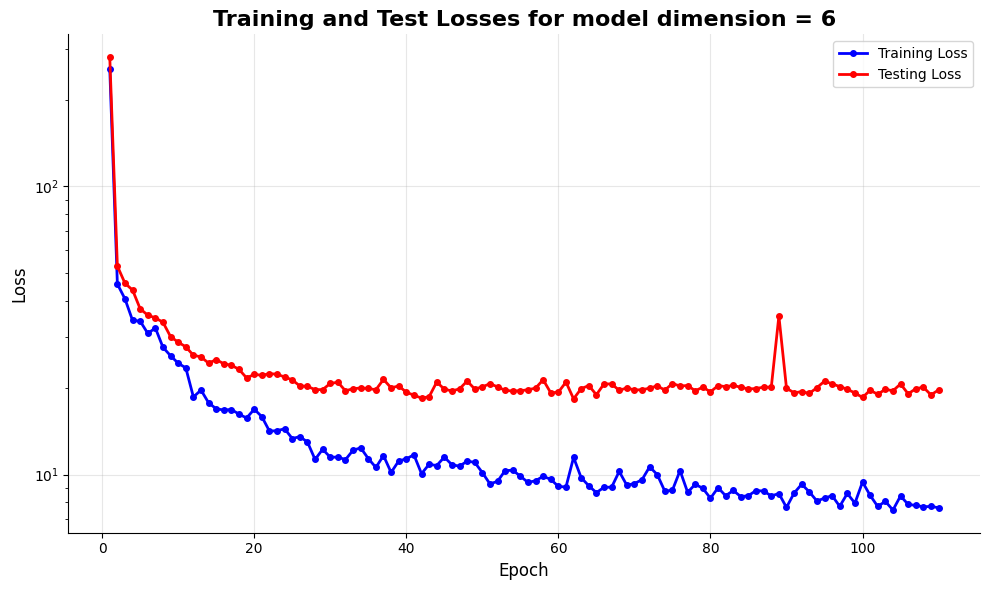

In [67]:
plot_loss(average_losses, test_losses, 6)

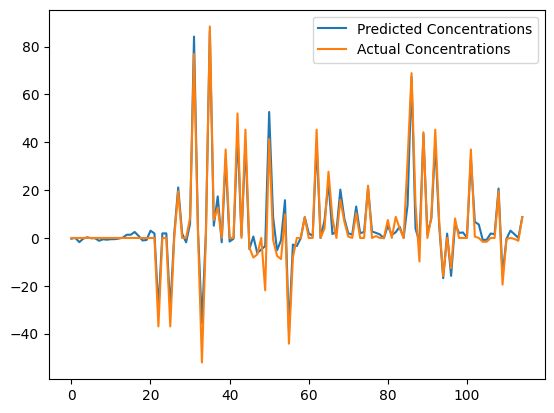

In [68]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [69]:
average_losses_12_3_5_2, test_losses_12_3_5_2, trained_model_12_3_5_2 = train_model(12,3,5,2)

Adjusted batch size for Mac GPU: 10
Epoch [440/2200] completed. Average Training Loss:  8.5123, Test Loss:  16.2402
Epoch [880/2200] completed. Average Training Loss:  5.5296, Test Loss:  15.6634
Epoch [1320/2200] completed. Average Training Loss:  3.6665, Test Loss:  16.2950
Epoch [1760/2200] completed. Average Training Loss:  2.7475, Test Loss:  16.4725
Epoch [2200/2200] completed. Average Training Loss:  2.8501, Test Loss:  15.9840
Training Completed


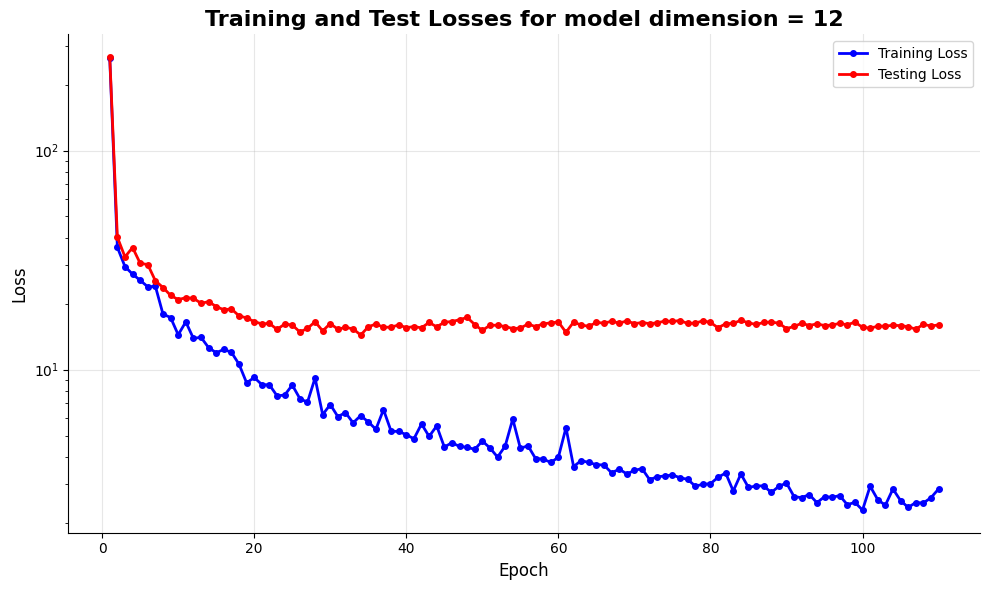

In [70]:
plot_loss(average_losses_12_3_5_2, test_losses_12_3_5_2, 12)

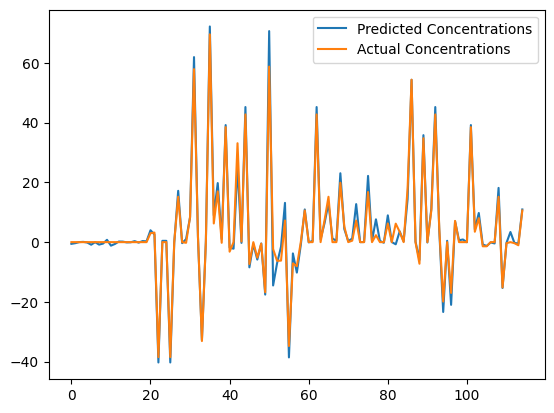

In [71]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_12_3_5_2(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [72]:
average_losses_12_3_5_3, test_losses_12_3_5_3, trained_model_12_3_5_3 = train_model(12,3,5,3)

Adjusted batch size for Mac GPU: 10
Epoch [440/2200] completed. Average Training Loss:  5.6180, Test Loss:  14.7959
Epoch [880/2200] completed. Average Training Loss:  2.4613, Test Loss:  15.6323
Epoch [1320/2200] completed. Average Training Loss:  1.5137, Test Loss:  15.9350
Epoch [1760/2200] completed. Average Training Loss:  1.1300, Test Loss:  15.5247
Epoch [2200/2200] completed. Average Training Loss:  0.9322, Test Loss:  15.4678
Training Completed


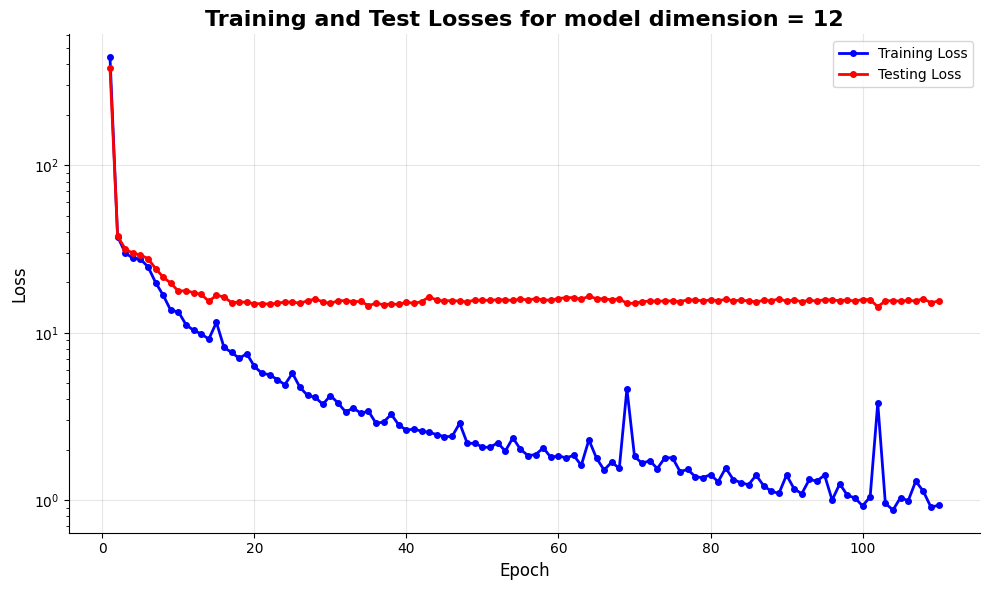

In [73]:
plot_loss(average_losses_12_3_5_3, test_losses_12_3_5_3, 12)

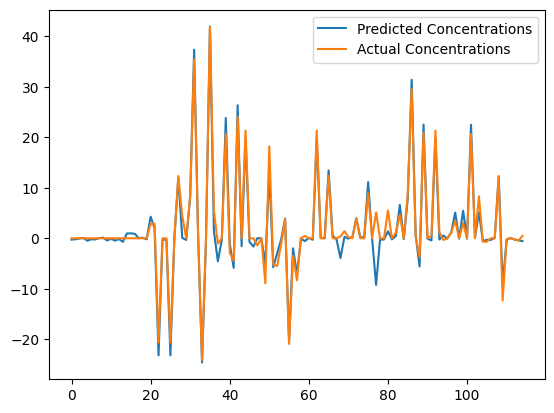

In [74]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_12_3_5_3(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [75]:
average_losses_16_4_4_2, test_losses_16_4_4_2, trained_model_16_4_4_2 = train_model(16,4,4,2)

Adjusted batch size for Mac GPU: 10
Epoch [440/2200] completed. Average Training Loss:  6.6685, Test Loss:  14.2473
Epoch [880/2200] completed. Average Training Loss:  4.4414, Test Loss:  14.1219
Epoch [1320/2200] completed. Average Training Loss:  2.8489, Test Loss:  15.6681
Epoch [1760/2200] completed. Average Training Loss:  2.1037, Test Loss:  14.5018
Epoch [2200/2200] completed. Average Training Loss:  1.6289, Test Loss:  14.2190
Training Completed


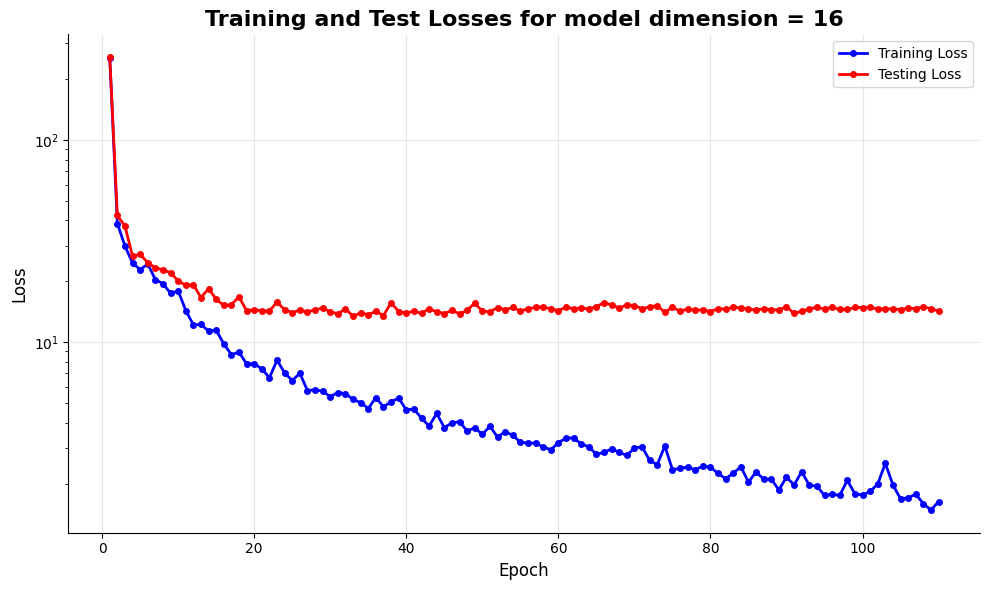

In [76]:
plot_loss(average_losses_16_4_4_2, test_losses_16_4_4_2, 16)

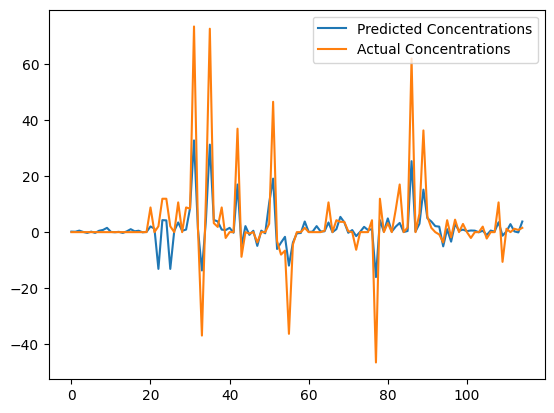

In [77]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_16_4_4_2(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [78]:
average_losses_16_4_4_3, test_losses_16_4_4_3, trained_model_16_4_4_3 = train_model(16,4,4,3)

Adjusted batch size for Mac GPU: 10


KeyboardInterrupt: 

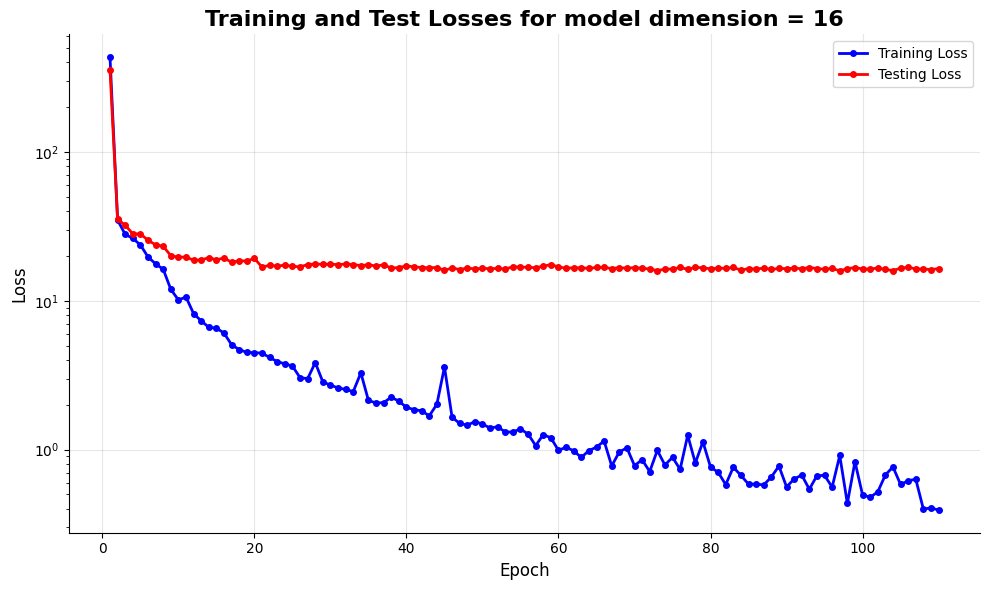

In [ ]:
plot_loss(average_losses_16_4_4_3, test_losses_16_4_4_3, 16)

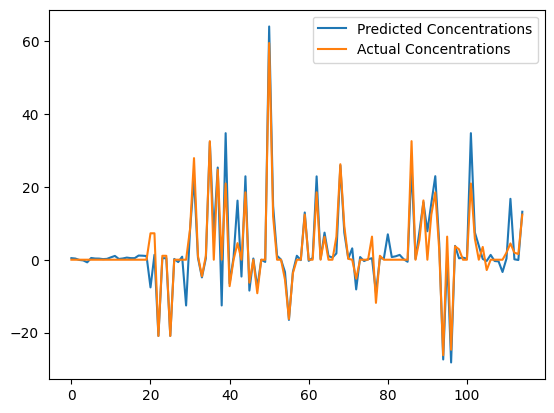

: 

In [ ]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_16_4_4_2(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [ ]:
average_losses_20_4_8_2, test_losses_20_4_8_2, trained_model_20_4_8_2 = train_model(20,4,8,2)

Adjusted batch size for Mac GPU: 12


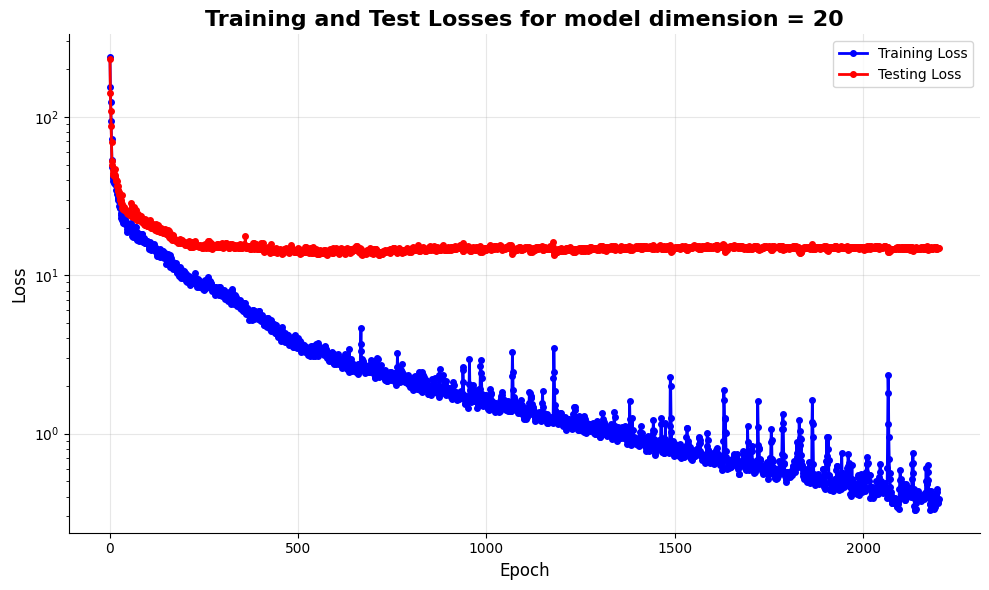

In [ ]:
plot_loss(average_losses_20_4_8_2, test_losses_20_4_8_2, 20)

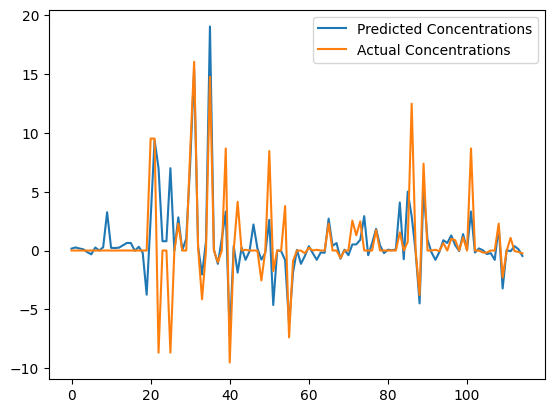

In [ ]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_20_4_8_2(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [51]:
average_losses_20_4_8_3, test_losses_20_4_8_3, trained_model_20_4_8_3 = train_model(20,4,8,3)

Adjusted batch size for Mac GPU: 10
Epoch [440/2200] completed. Average Training Loss:  5.7534, Test Loss:  20.4190
Epoch [880/2200] completed. Average Training Loss:  1.2762, Test Loss:  20.6523
Epoch [1320/2200] completed. Average Training Loss:  0.4511, Test Loss:  20.0599


KeyboardInterrupt: 

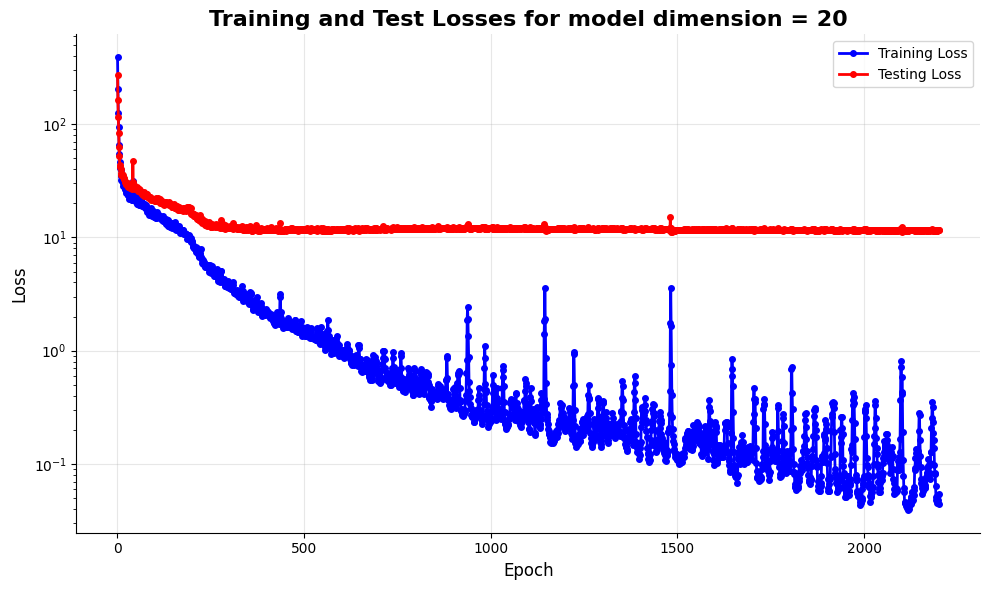

In [ ]:
plot_loss(average_losses_20_4_8_3, test_losses_20_4_8_3, 20)

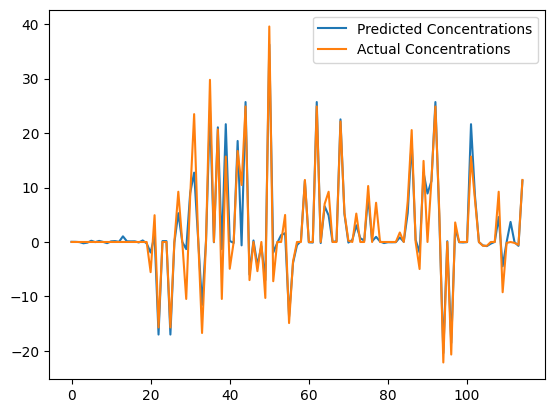

In [ ]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_20_4_8_3(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)

plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [ ]:
inps_test_.size()

torch.Size([19910, 115, 1])

In [ ]:
# Sanity Check on the test data
j = np.random.randint(0,inps_test_.size(0),1)[0]
pred_ops = trained_model_20_4_8_3(inps_test_[j,:,:].unsqueeze(0))
target_ops = outs_test_[j,:,:].unsqueeze(0)



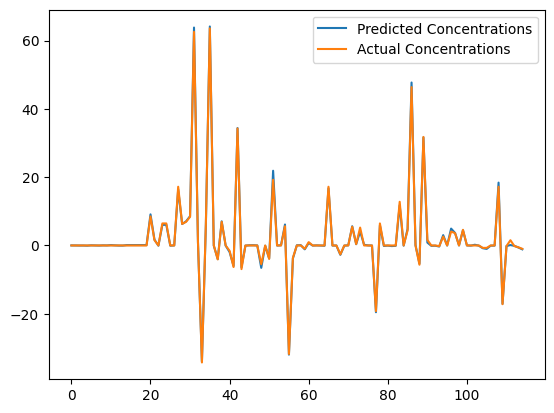

In [ ]:
plt.plot(pred_ops[0,:,0].cpu().detach().numpy(),label='Predicted Concentrations')
plt.plot(target_ops[0,:,0].cpu().detach().numpy(),label='Actual Concentrations')
plt.legend()
plt.show()

In [ ]:
average_losses_20_4_8_4, test_losses_20_4_8_4, trained_model_20_4_8_4 = train_model(20,4,8,4)

Adjusted batch size for Mac GPU: 12
Epoch [440/2200] completed. Average Training Loss:  2.8399, Test Loss:  13.5491
Epoch [880/2200] completed. Average Training Loss:  0.5808, Test Loss:  13.1506
Epoch [1320/2200] completed. Average Training Loss:  0.2284, Test Loss:  13.1112
Epoch [1760/2200] completed. Average Training Loss:  0.3509, Test Loss:  12.6960


KeyboardInterrupt: 

In [ ]:
plot_loss(average_losses_20_4_8_4, test_losses_20_4_8_4, 20)

In [ ]:
print(sum( p.numel() for p in trained_model.parameters() if p.requires_grad  ))

15458


In [ ]:
print(sum( p.numel() for p in trained_model_12_3_5_2.parameters() if p.requires_grad  ))

19604


In [ ]:
print(sum( p.numel() for p in trained_model_16_4_4_2.parameters() if p.requires_grad  ))

22346


In [ ]:
print(sum( p.numel() for p in trained_model_20_4_8_2.parameters() if p.requires_grad  ))

33734


In [ ]:
print(sum( p.numel() for p in trained_model_20_4_8_3.parameters() if p.requires_grad  ))